# Linear hillslope diffusion model for Eightmile Lake, AK

## Inputs: DEM, resampled to 30m resolution
## Components: LinearDiffuser
## Outputs: Soil depth

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import rasterio as rio

from landlab import RasterModelGrid
from landlab.plot import imshow_grid
from landlab.components import LinearDiffuser

/home/egp/.virtualenvs/landlab/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
current = 2 # meters per pixel
target = 30 # meters per pixel
scale = current / target

with rio.open('./gis/projects/dem/eightmile-lake-watershed-dem-filled.tif') as src:

    # resample data to target shape
    data = src.read(
        out_shape = (
            src.count,
            int(src.height * scale),
            int(src.width * scale)
        ),
        resampling = rio.enums.Resampling.bilinear
    )

    # scale image transform
    transform = src.transform * src.transform.scale(
        (src.width / data.shape[-1]),
        (src.height / data.shape[-2])
    )

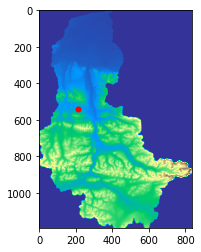

In [3]:
dem = np.flip(np.transpose(data[0]), 0)

plt.imshow(dem, cmap = 'terrain')
plt.scatter(210, 540, s = 25, color = 'red')
plt.show()

In [4]:
grid = RasterModelGrid([dem.shape[0], dem.shape[1]], target)

In [5]:
grid.add_field('topographic__elevation', np.flip(dem.astype(float), 0), at = 'node', clobber = True, copy = True) 

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [6]:
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__elevation'], 0)

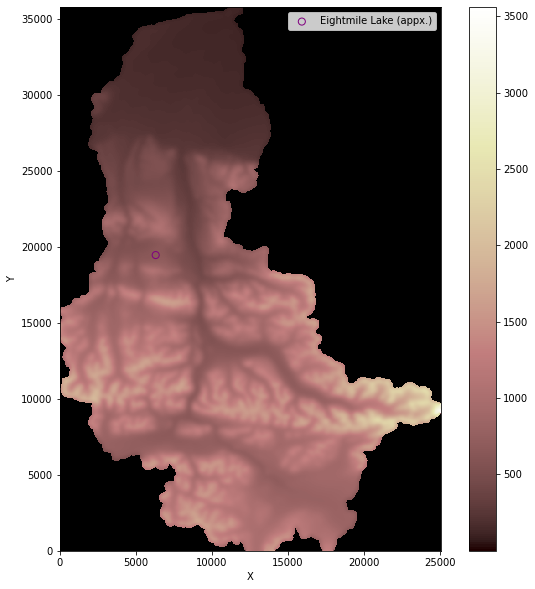

In [37]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, 'topographic__elevation')
plt.scatter(6300, 19440, s = 50, color = 'purple', facecolors = 'none', label = 'Eightmile Lake (appx.)')
plt.legend(loc = 'upper right')
plt.show()

In [8]:
LD = LinearDiffuser(grid, linear_diffusivity = 0.01, method = 'simple', deposit = True)

In [9]:
nt = 1000
dt = 1000
count = 0
initial_topo = grid.at_node['topographic__elevation'][:].copy()

for i in range(nt):
    LD.run_one_step(dt)
    
    count += 1
    if count % 100 == 0:
        print('Completed ' + str(count) + ' time steps.')

Completed 100 time steps.
Completed 200 time steps.
Completed 300 time steps.
Completed 400 time steps.
Completed 500 time steps.
Completed 600 time steps.
Completed 700 time steps.
Completed 800 time steps.
Completed 900 time steps.
Completed 1000 time steps.


In [38]:
change_in_topo = grid.at_node['topographic__elevation'] - initial_topo

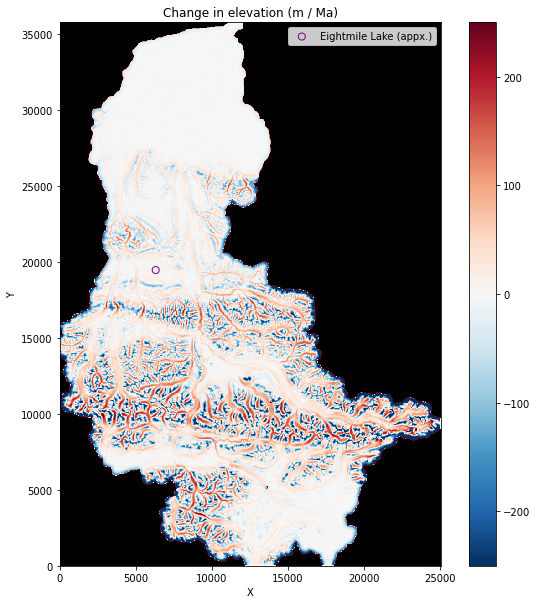

In [39]:
fig, ax = plt.subplots(figsize = (10, 10))
imshow_grid(grid, change_in_topo, cmap = 'RdBu_r', vmin = -250, vmax = 250)
plt.scatter(6300, 19440, s = 50, color = 'purple', facecolors = 'none', label = 'Eightmile Lake (appx.)')
plt.legend(loc = 'upper right')
plt.title('Change in elevation (m / Ma)')
plt.show()